In [1]:
from pybaseball import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np
import os
import lightgbm as lgb

%matplotlib inline

## Loading the Data

In [2]:
raw_data = pd.read_csv('data/data.csv')
speed_data = pd.read_csv('data/sprint_speed.csv')

C:\Users\Mark\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing

In [3]:
speed_data.rename({
    'last_name': 'batter_last_name',
    ' first_name': 'batter_first_name'
}, axis='columns', inplace=True)

data = raw_data.merge(speed_data[['batter_last_name', 'batter_first_name', 'player_id', 'sprint_speed']], left_on='batter', right_on='player_id')
data[['batter_last_name', 'batter_first_name', 'sprint_speed']].head()

,batter_last_name,batter_first_name,sprint_speed
0,Machado,Manny,26.6
1,Machado,Manny,26.6
2,Machado,Manny,26.6
3,Machado,Manny,26.6
4,Machado,Manny,26.6


In [4]:
# Create outcome feature as target variable. Include sac flies as outs.

is_hit = ['single', 'double', 'triple', 'home_run']
is_out = ['field_out', 'grounded_into_double_play', 'force_out', 'sac_fly', 'fielders_choice_out', 'fielders_choice', 'field_error', 'triple_play']

data = data[data.events.isin(is_hit) | data.events.isin(is_out)]
data['outcome'] = np.where(data.events.isin(is_hit), data.events, 'out')

In [5]:
# Grab only the records and features we're interested in, drop nans

features_of_interest = ['launch_speed', 'launch_angle', 'hc_x', 'hc_y', 'sprint_speed', 'home_team', 'outcome']
numerical_features = ['launch_speed', 'launch_angle', 'hc_x', 'hc_y', 'sprint_speed']
categorical_features = ['home_team', 'outcome']
bb_events = ['ground_ball', 'fly_ball', 'popup', 'line_drive']
data = data[data.bb_type.isin(bb_events)][features_of_interest]
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
data.head()

(271595, 7)
(271166, 7)


,launch_speed,launch_angle,hc_x,hc_y,sprint_speed,home_team,outcome
4,99.2,9.0,101.62,143.38,26.6,LAD,out
21,79.9,-9.0,98.79,171.35,26.6,LAD,out
25,104.8,12.0,159.00,64.82,26.6,LAD,single
34,85.2,37.0,161.17,84.05,26.6,LAD,out
40,59.2,68.0,135.29,165.78,26.6,LAD,out


In [41]:
# Convert categorical string variables to integers

feature = data['home_team'].unique().tolist()
mapping = dict(zip(feature, range(len(feature))))
data.replace({'home_team': mapping},inplace=True)

feature = data['outcome'].unique().tolist()
mapping = dict(zip(feature, range(len(feature))))
data.replace({'outcome': mapping},inplace=True)

ValueError: Replacement not allowed with overlapping keys and values

In [28]:
seed = 34
np.random.seed(seed)

# All but the last item in features_of_interest are variables
X = data[features_of_interest[:-1]]
y = data[features_of_interest[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed)

In [23]:
features_of_interest[-1]

'outcome'

In [62]:
train_data = lgb.Dataset(X_train, label=y_train, feature_name=features_of_interest[:-1], categorical_feature=[5], free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, feature_name=features_of_interest[:-1], categorical_feature=[5], free_raw_data=False)
validation_data = lgb.Dataset(X_val, label=y_val, feature_name=features_of_interest[:-1], categorical_feature=[5], free_raw_data=False)

In [83]:
params = {
    "objective" : "multiclass",
    "metric": 'multi_logloss',
    "num_class": 5,
    "num_leaves": 40,
    "max_depth": 10,
    "learning_rate": 0.01,
    "bagging_fraction": 0.9,  # subsample
    "feature_fraction": 0.9,  # colsample_bytree
    "bagging_freq": 5,        # subsample_freq
    "bagging_seed": seed,
    "min_data_in_leaf": 100,
    #"lambda_l1": 0.3,
    #"lambda_l2": 0.3,
    "verbosity": 1
}

In [86]:
# Perform grid search

leaves = [20, 40, 60, 80]
depth = [10, 30, -1]
run_num = 1

for num_leaves in leaves:
    for max_depth in depth:
        print(f'Attempting run {run_num} with num_leaves = {num_leaves} and max_depth = {max_depth}')
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth
        run_num += 1
        lgb.train(params, train_data, 2000, valid_sets=[train_data, validation_data], early_stopping_rounds=100, verbose_eval=500)

Attempting run 1 with num_leaves = 20 and max_depth = 10
Training until validation scores don't improve for 100 rounds.
[500]	training's multi_logloss: 0.368081	valid_1's multi_logloss: 0.377154
[1000]	training's multi_logloss: 0.313239	valid_1's multi_logloss: 0.326969
[1500]	training's multi_logloss: 0.292876	valid_1's multi_logloss: 0.311391
[2000]	training's multi_logloss: 0.280927	valid_1's multi_logloss: 0.304128
Did not meet early stopping. Best iteration is:
[2000]	training's multi_logloss: 0.280927	valid_1's multi_logloss: 0.304128
Attempting run 2 with num_leaves = 20 and max_depth = 30
Training until validation scores don't improve for 100 rounds.
[500]	training's multi_logloss: 0.368077	valid_1's multi_logloss: 0.377137
[1000]	training's multi_logloss: 0.313251	valid_1's multi_logloss: 0.327032
[1500]	training's multi_logloss: 0.292845	valid_1's multi_logloss: 0.311388
[2000]	training's multi_logloss: 0.280891	valid_1's multi_logloss: 0.304098
Did not meet early stopping. B

In [ ]:
lgb.cv(
    params=params,
    train_set=train_data,
    num_boost_round=4000,
    early_stopping_rounds=100,
    nfold=5,
    verbose_eval=200,
    callbacks=lgb.early_stopping(100, )
)

In [84]:
lgbmodel = lgb.train(params, train_data, 2000, valid_sets=[train_data, validation_data], early_stopping_rounds=100, verbose_eval=200)

Training until validation scores don't improve for 100 rounds.
[200]	training's multi_logloss: 0.479205	valid_1's multi_logloss: 0.488674
[400]	training's multi_logloss: 0.370431	valid_1's multi_logloss: 0.383298
[600]	training's multi_logloss: 0.326756	valid_1's multi_logloss: 0.343338
[800]	training's multi_logloss: 0.304392	valid_1's multi_logloss: 0.324673
[1000]	training's multi_logloss: 0.289808	valid_1's multi_logloss: 0.313698
[1200]	training's multi_logloss: 0.27956	valid_1's multi_logloss: 0.307044
[1400]	training's multi_logloss: 0.271515	valid_1's multi_logloss: 0.302526
[1600]	training's multi_logloss: 0.265068	valid_1's multi_logloss: 0.29954
[1800]	training's multi_logloss: 0.259406	valid_1's multi_logloss: 0.297134
[2000]	training's multi_logloss: 0.254462	valid_1's multi_logloss: 0.295472
Did not meet early stopping. Best iteration is:
[2000]	training's multi_logloss: 0.254462	valid_1's multi_logloss: 0.295472


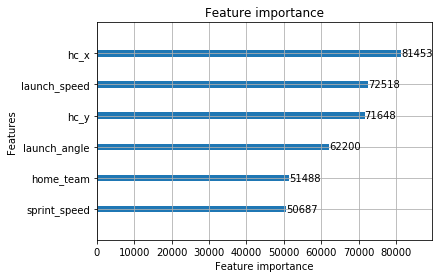

In [85]:
lgb.plot_importance(lgbmodel)